In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [132]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [5]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [161]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../dataset/data3c.txt'
data0Label = r'../dataset/data3clabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

In [ ]:
from pandas.core.common import flatten

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=20)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=2,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

14.437796592712402
13.855722427368164


In [157]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

Accuracy: 0.45


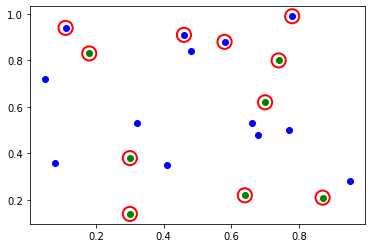

In [163]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

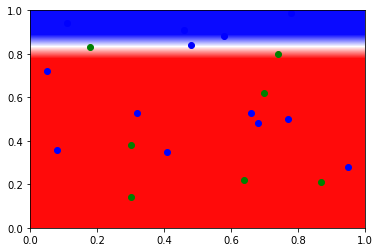

In [164]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1a

In [ ]:
data1aPath = r'../dataset/data1a.txt'
data1aLabel = r'../dataset/data1alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1b

True

In [ ]:
data1bPath = r'../dataset/data1b.txt'
data1bLabel = r'../dataset/data1blabel.txt'

dataCoords = np.loadtxt(data1bPath)
dataLabels = np.loadtxt(data1bLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1c

In [ ]:
data1aPath = r'../dataset/data1c.txt'
data1aLabel = r'../dataset/data1clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2a

In [ ]:
data1aPath = r'../dataset/data2a.txt'
data1aLabel = r'../dataset/data2alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2b

In [ ]:
data1aPath = r'../dataset/data2b.txt'
data1aLabel = r'../dataset/data2blabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2c

In [ ]:
data1aPath = r'../dataset/data2c.txt'
data1aLabel = r'../dataset/data2clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3a

In [ ]:
data1aPath = r'../dataset/data3a.txt'
data1aLabel = r'../dataset/data3alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3b

In [ ]:
data1aPath = r'../dataset/data3b.txt'
data1aLabel = r'../dataset/data3blabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3c

In [ ]:
data1aPath = r'../dataset/data3c.txt'
data1aLabel = r'../dataset/data3clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters(),lr=0.01,tolerance_grad=1e-09, tolerance_change=1e-11)
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [ ]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)